In [35]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from collections import Counter

## Data preprocessing

In [3]:
# Train and test dataset paths
train_path = "/kaggle/input/standard-ocr-dataset/data/training_data/"
test_path  = "/kaggle/input/standard-ocr-dataset/data/testing_data/"

In [4]:
# Get lables
labels = os.listdir(train_path)

In [5]:
# Define constants for training
IMG_SHAPE = (64, 64)
INPUT_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1], 3)
BATCH_SIZE = 64
EPOCHS = 10
LOSS = 'categorical_crossentropy'

In [6]:
# Function to load data in given a file path
def get_data(filepath):
    images = []
    classes = []
    
    labels = os.listdir(filepath)
    for image_class in labels:

        ims = os.listdir(os.path.join(filepath, image_class))

        for i in range(0, len(ims)):

            im = cv2.imread(os.path.join(filepath, image_class, ims[i]))

            # Preprocessing steps
            if im is not None:
                # Reshape image to defined size
                im = cv2.resize(im, IMG_SHAPE) 
                
                # Create np array of type float32
                im = np.array(im, dtype=np.float32)

                # Normalise image
                im = im / 255
                
                images.append(im)
                classes.append(image_class)            
            else:
                print(i, ims[i], image_class)
        
    return np.array(images), np.array(classes)

In [7]:
# Get test and train data
train_X, train_Y = get_data(train_path)
test_X, test_Y = get_data(test_path)

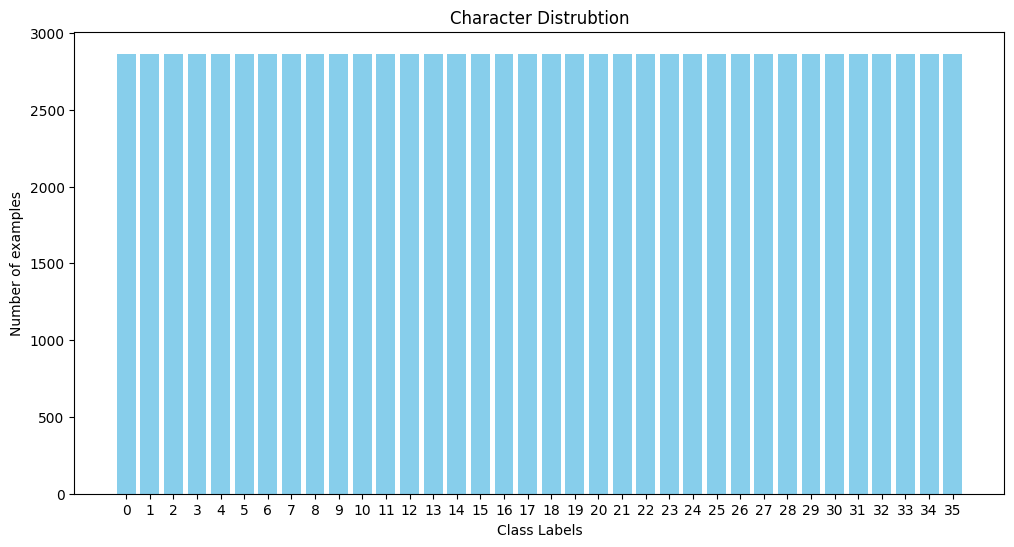

In [43]:
# Count each class 
y_labels_count = Counter(train_Y)
labels, counts = zip(*y_labels_count.items())

# Plot counts 
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Number of examples')
plt.title('Character Distrubtion')

# Optionally set x-tick labels (if needed)
plt.xticks(labels)

# Show the plot
plt.show()

In [8]:
# Look at shape of training data
train_X.shape

(20628, 64, 64, 3)

In [9]:
train_X.shape[0] == train_Y.shape[0] and test_X.shape[0] == test_Y.shape[0]

True

In [10]:
# One hot encode labels
le = LabelEncoder()
train_Y = le.fit_transform(train_Y)

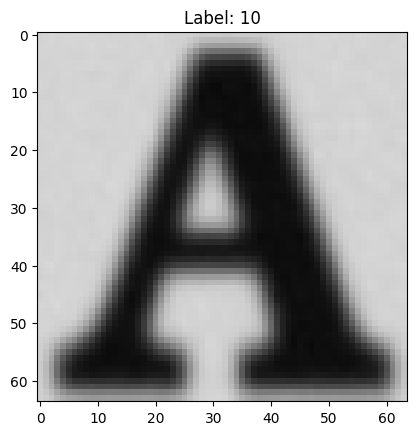

In [11]:
# Check image
test_image = 12022
plt.imshow(train_X[test_image], cmap="gray")
plt.title(f"Label: {train_Y[test_image]}")
plt.show()

In [12]:
# Data augmentation object
datagen = ImageDataGenerator(
    rotation_range=10, # Rotation +- 10 degrees
    width_shift_range=0.1, # Shift image horizontally +- 10%
    height_shift_range=0.1, # Shift image vertically +- 10%
    shear_range=0.2, # Sheering +- 20%
    zoom_range=0.2, # Zoom in +- 20%
    horizontal_flip=False,  # Don't flip for characters
    vertical_flip=False,  # Don't flip for characters
    fill_mode='nearest'
)

In [13]:
# Augment all the original data and place back into np arrays
augmented_arr_X = []
augmented_arr_Y = []

# Augment each image 5 times
for i in range(len(train_X)):
    image_expanded = np.expand_dims(train_X[i], axis=0)
    
    # Generate 5 augmented images
    iterator = datagen.flow(image_expanded, batch_size=1)
    for _ in range(5):
        augmented_image = iterator.__next__()[0]  # Get the next augmented image
        augmented_arr_X.append(augmented_image)
        augmented_arr_Y.append(train_Y[i])

# Convert lists to numpy arrays
X = np.array(augmented_arr_X)
Y = np.array(augmented_arr_Y)

In [14]:
X.shape

(103140, 64, 64, 3)

In [15]:
Y.shape

(103140,)

In [16]:
# Shuffle data (in the same way each time)
train_X, train_Y = shuffle(X, Y, random_state=42)

In [17]:
# Shuffle test data
test_X, test_Y = shuffle(test_X, test_Y, random_state=42)

# One hot encode test data
le = LabelEncoder()
test_Y = le.fit_transform(test_Y)

## Training

In [18]:
def create_model(filters, units):
    """
    Create the model given the filters and units
    
    Parameters:
    filters (list(int)): List of filters to test
    units (list(int)): List of units to test
    """
    
    model = Sequential()
    
    model.add(Conv2D(filters=filters[0], kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=filters[1], kernel_size=(3,3),  activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=filters[2], kernel_size=(3,3),  activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=filters[3], kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    
    model.add(Dense(units=units[0], activation='relu'))
    
    model.add(Dense(units=units[1], activation='relu'))
    
    model.add(Dense(units=36, activation='softmax'))
    
    return model

In [18]:
# Test filters and units in model

filters_to_test = [[16, 32, 64, 128], [16, 16, 16, 32], [16, 32, 64, 64], [16, 32, 64, 64]]
units_to_test = [[128, 64], [64, 64], [32, 32], [32, 64]]

for i in range(len(filters_to_test)):
    # Get the filters and units to test
    filters = filters_to_test[i]
    units = units_to_test[i]
    
    # Run training with filters and units
    model = create_model(filters, units)
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    # Fit the model
    history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE, validation_split=0.2, epochs=EPOCHS, verbose=0)
    
    # Check accuracy and loss
    test_loss, test_accuracy = model.evaluate(test_X, test_Y, verbose=0)
    
    # Print the architecture, accuracy and loss
    print("--------------------------------")
    print(f"Model architecture: {filters + units}")
    print(f"Test accuracy: {round(test_accuracy*100, 2)}% \t Test loss: {test_loss}")
    print("--------------------------------")
    print()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1724270728.712571     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724270728.737211     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724270737.431011     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724270740.361624     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724270742.208806     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

--------------------------------
Model architecture: [16, 32, 64, 128, 128, 64]
Test accuracy: 98.12% 	 Test loss: 0.038488712161779404
--------------------------------

--------------------------------
Model architecture: [16, 16, 16, 32, 64, 64]
Test accuracy: 98.02% 	 Test loss: 0.04426966607570648
--------------------------------



W0000 00:00:1724270900.418909     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724270910.906192     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724270912.458460     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


--------------------------------
Model architecture: [16, 32, 64, 64, 32, 32]
Test accuracy: 97.82% 	 Test loss: 0.05502009019255638
--------------------------------



W0000 00:00:1724270987.978052     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724270998.374563     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724270999.754098     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


--------------------------------
Model architecture: [16, 32, 64, 64, 32, 64]
Test accuracy: 97.92% 	 Test loss: 0.04563535004854202
--------------------------------



In [19]:
# Choose best model and train

# Best filters and units found
filters = [16, 32, 64, 128]
units = [128, 64]

 # Run training with filters and units
model = create_model(filters, units)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

# Fit the model
history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE, validation_split=0.2, epochs=EPOCHS)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
  33/1290 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0306 - loss: 3.5817    

I0000 00:00:1724275197.454702     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724275197.477753     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6258 - loss: 1.3094

W0000 00:00:1724275206.475026     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724275209.365033     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6259 - loss: 1.3089 - val_accuracy: 0.9138 - val_loss: 0.2747
Epoch 2/10
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9239 - loss: 0.2283 - val_accuracy: 0.9392 - val_loss: 0.1826
Epoch 3/10
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9451 - loss: 0.1559 - val_accuracy: 0.9427 - val_loss: 0.1690
Epoch 4/10
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9549 - loss: 0.1270 - val_accuracy: 0.9530 - val_loss: 0.1426
Epoch 5/10
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9623 - loss: 0.1031 - val_accuracy: 0.9532 - val_loss: 0.1410
Epoch 6/10
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9666 - loss: 0.0894 - val_accuracy: 0.9545 - val_loss: 0.1352
Epoch 7/10
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9696 - loss: 0.0814 - val_accuracy: 0.9576 - val_loss: 0.1313
Epoch 8/10
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9739 - loss: 0.0683 - val_accur

In [20]:
# Check accuracy and loss
test_loss, test_accuracy = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test accuracy: {round(test_accuracy*100, 2)}% \t Test loss: {test_loss}")

Test accuracy: 96.73% 	 Test loss: 0.05716034770011902


W0000 00:00:1724275278.827589     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Model evaluation

In [21]:
# Get the keys
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

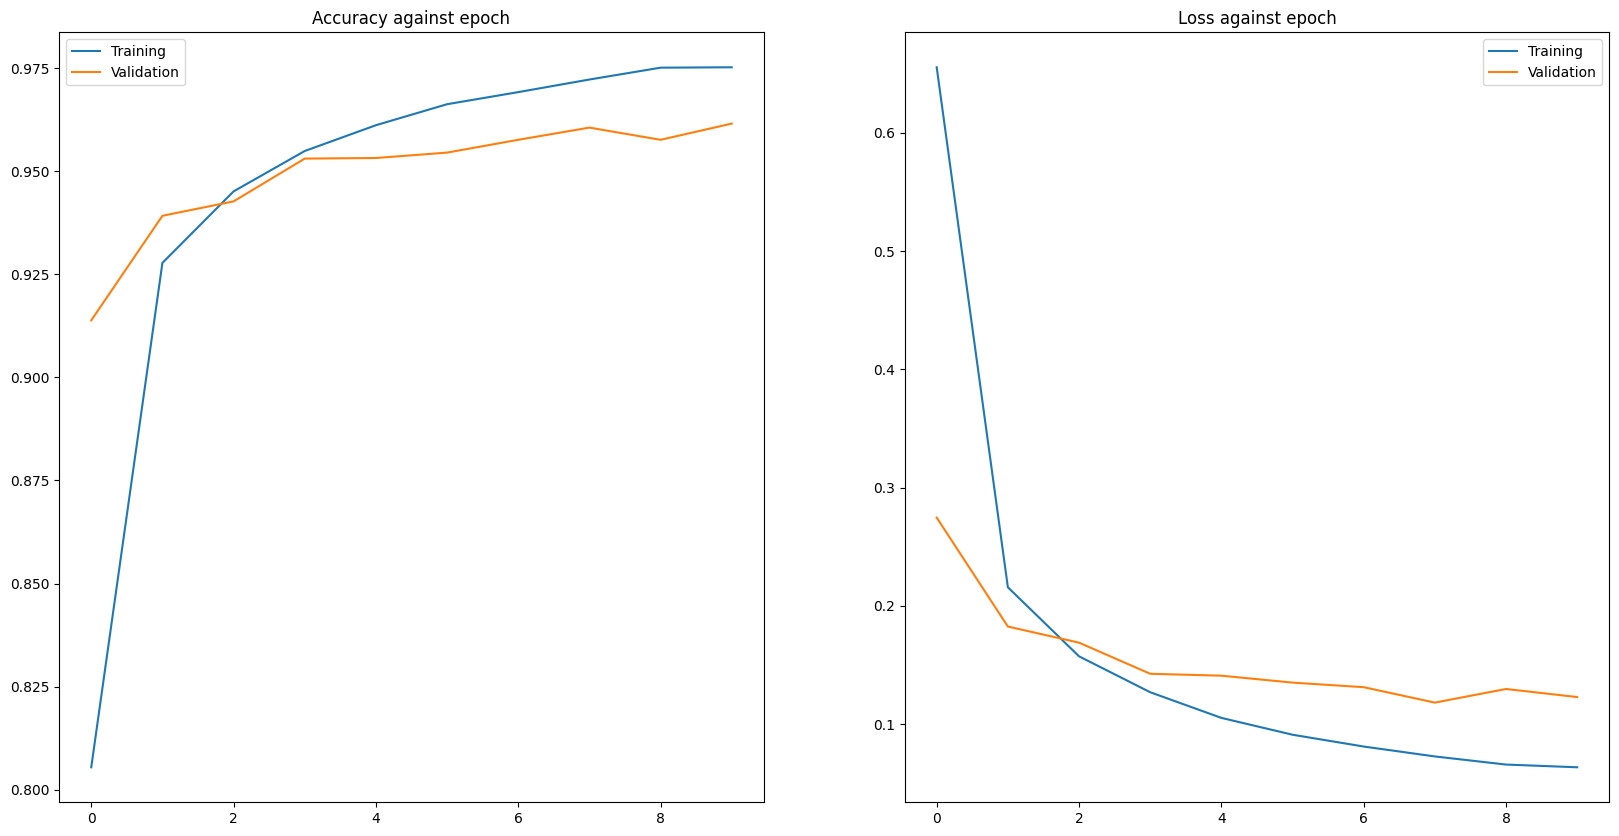

In [22]:
# Plot val and train accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed
labels = ["Training", "Validation"]
# Plot accuracy data
axes[0].set_title("Accuracy against epoch")
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(labels)

# Plot loss data
axes[1].set_title("Loss against epoch")
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(labels)

plt.show()

In [23]:
test_Y = le.inverse_transform(test_Y)
test_Y_pred = model.predict(test_X)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


W0000 00:00:1724275280.455030     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [24]:
test_Y_pred = np.argmax(test_Y_pred, axis=1)
test_Y_pred = le.inverse_transform(test_Y_pred)

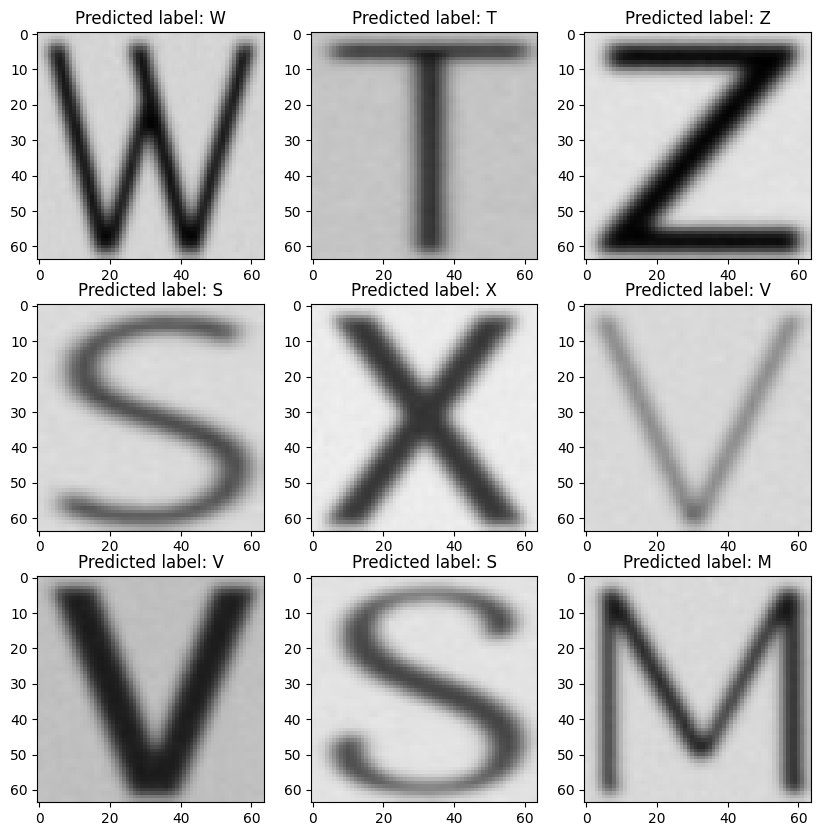

In [25]:
# Look at sample of 10 test data items
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))  # Adjust figsize as needed
axes = axes.flatten()
# Go through 
for i in range(rows * cols):
    axes[i].imshow(test_X[i])
    axes[i].set_title(f"Predicted label: {test_Y_pred[i]}")
plt.show()

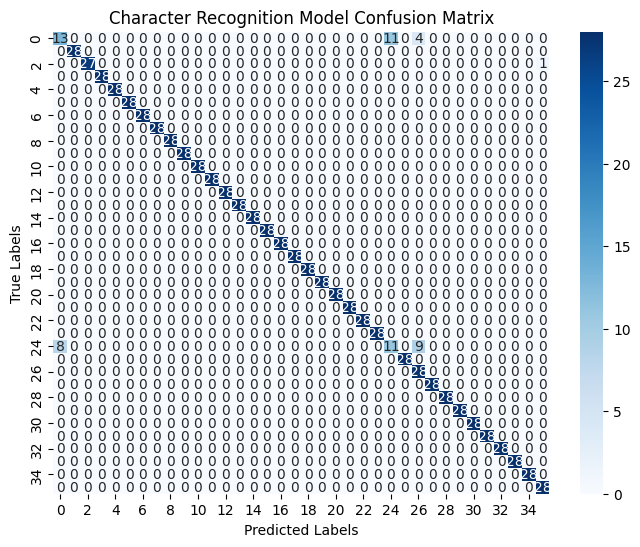

In [33]:
# Calculate confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Character Recognition Model Confusion Matrix')

# Show the plot
plt.show()

In [27]:
model.save('character_recognition_model.h5')